## Benjamin Lee and Hyung-Seok Seo Collaborated

# Mcdonalds Yelp Reviews

A. Using the **McDonalds Yelp Review CSV file**, **process the reviews**.
This means you should think briefly about:
* what stopwords to remove (should you add any custom stopwords to the set? Remove any stopwords?)
* what regex cleaning you may need to perform (for example, are there different ways of saying `hamburger` that you need to account for?)
* stemming/lemmatization (explain in your notebook why you used stemming versus lemmatization). 

Next, **count-vectorize the dataset**. Use the **`sklearn.feature_extraction.text.CountVectorizer`** examples from `Linear Algebra, Distance and Similarity (Completed).ipynb` and `Text Preprocessing Techniques (Completed).ipynb`.

I do not want redundant features - for instance, I do not want `hamburgers` and `hamburger` to be two distinct columns in your document-term matrix. Therefore, I'll be taking a look to make sure you've properly performed your cleaning, stopword removal, etc. to reduce the number of dimensions in your dataset. 

## Load Libraries and Data


In [1]:
import re
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from matplotlib.pyplot import figure
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\drpow\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\drpow\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
text = pd.read_csv('mcdonalds-yelp-negative-reviews.csv', encoding="ISO-8859-1")
mcd = pd.read_csv('mcdonalds-yelp-negative-reviews.csv', encoding="ISO-8859-1")


## Cleaning and Stopword removal

Lets clean up the data by checking and removing garbage values (this code stolen from my previous HW), and then lets remove stopwords based on our custom list

In [3]:
def find_unique_characters(regex, lines):
    """
    Finds unique characters from a list of strings, almost certainly inefficiently 
    
    """
    #Match anything that is non alpha-numeric or whitespace, creates list of lists of matching characters
    potential_malforms = [re.findall(regex, review) for review in lines]

    #lets whittle down this list of lists to a unqiue list, btw this took me way longer than it needed to
    unique_malforms = set([char for review in potential_malforms for char in review])
    
    print(F"Number of unique potential Malformed Characters: {len(unique_malforms)}, \n\nCandidates: {unique_malforms}")
    return unique_malforms

## Utility functions

In [4]:
def cleaner(data):
    cleaned=[" ".join(re.findall("[a-zA-z0-9]+",i)).lower() for i in data]
    return cleaned

def count_words(lines, delimiter=" "):
    
    words = Counter() # instantiate a Counter object called words
    for line in lines:
        for word in line.split(delimiter):
            words[word] += 1 # increment count for word
    return words

def key_finder(data,keyword):
    if type(keyword)!=list:
        print('Please pass a listed form for keyword')
    temp_list = []
    keyword_list=[]
    i_index_list=[]
    for i in keyword:
        keyword_list.append(i)
        alt_keyword=i+'s'
        keyword_list.append(alt_keyword)
        keyword_list.append(i.upper()) #Capitalized keyword
        keyword_list.append(i.lower()) #Uncapitalized keyword
        keyword_list.append(alt_keyword.upper()) #Capitalized plural keyword
        keyword_list.append(alt_keyword.lower() ) #Uncapitalized plural keyword
    #Make a re string using the keywords
    res=r'(\b'
    for i in keyword_list:
        if i!=keyword_list[-1]:
            res += i
            res += '|'
        else:
            res +=i
    res +='\b)'
    i_index=0
    for i in data:
        match = re.search(res,i)
        if match:
            end = re.sub('[-=,#/?:$}]+[0-9]+','',i)
            temp_list.append(end.lower())
            i_index_list.append(i_index)
        i_index+=1
    emp_df=pd.DataFrame()
    emp_df['matched_review']=temp_list
    emp_df['i_index']=i_index_list
    emp_df.set_index('i_index',inplace=True)
    return emp_df

### Remove Stopwords and Group Common Concepts Then Lemmatize

I chose lemmatization since we are not feeding this into any ML models we do not need to worry about overfitting, and lemmatization has the added benefit of being easier to understand since we are working with entire words instead of roots 

Also we will remove numbers with regex because otherwise it really clouds the data

In [5]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

### Find some words we may want to remove with other stopwords

In [6]:
#lets get the top words so we can find other words we may want to remove as stopwords
tot_words = []
for idx, review in mcd.iterrows():
    words = re.sub(r"[^A-Za-z0-9 ]",'',review['review'])
    tot_words.extend(word_tokenize(words))
    
Counter(list(tot_words)).most_common()

[('the', 6220),
 ('I', 4368),
 ('and', 4099),
 ('to', 4015),
 ('a', 3439),
 ('of', 1999),
 ('is', 1913),
 ('was', 1789),
 ('in', 1771),
 ('for', 1644),
 ('my', 1416),
 ('this', 1409),
 ('it', 1402),
 ('that', 1238),
 ('McDonalds', 1209),
 ('they', 1142),
 ('you', 1115),
 ('at', 1018),
 ('have', 949),
 ('not', 903),
 ('on', 902),
 ('but', 839),
 ('me', 836),
 ('with', 812),
 ('order', 807),
 ('food', 807),
 ('The', 752),
 ('are', 707),
 ('one', 672),
 ('get', 662),
 ('be', 640),
 ('so', 624),
 ('there', 588),
 ('up', 568),
 ('here', 565),
 ('had', 564),
 ('just', 537),
 ('time', 512),
 ('go', 505),
 ('or', 499),
 ('out', 489),
 ('drive', 479),
 ('like', 478),
 ('as', 467),
 ('no', 461),
 ('service', 458),
 ('were', 453),
 ('place', 449),
 ('when', 448),
 ('its', 422),
 ('your', 413),
 ('This', 405),
 ('only', 396),
 ('all', 391),
 ('if', 382),
 ('because', 380),
 ('what', 377),
 ('dont', 376),
 ('their', 372),
 ('location', 371),
 ('been', 364),
 ('about', 364),
 ('an', 361),
 ('from', 

## Webscraping McDonalds Menu

In [7]:
import requests
from bs4 import BeautifulSoup
#Burger Menu list
url='https://www.mcdonalds.com/us/en-us/full-menu/burgers.html'
response = requests.get(url)
html=response.text
soup = BeautifulSoup(html,'html.parser')
burger_menu=[i.get_text() for i in soup.find_all('span',{'class':'categories-item-name'})]
cleaned_burger_menu = cleaner(burger_menu)
#Drinks Menu list
url='https://www.mcdonalds.com/us/en-us/full-menu/drinks.html'
response = requests.get(url)
html=response.text
soup = BeautifulSoup(html,'html.parser')
drink_menu=[i.get_text() for i in soup.find_all('span',{'class':'categories-item-name'})]
cleaned_drink_menu = cleaner(drink_menu)
#Breakfast Menu list
url='https://www.mcdonalds.com/us/en-us/full-menu/breakfast.html'
response = requests.get(url)
html=response.text
soup = BeautifulSoup(html,'html.parser')
breakfast_menu=[i.get_text() for i in soup.find_all('span',{'class':'categories-item-name'})]
cleaned_breakfast_menu = cleaner(breakfast_menu)
#Dessert Menu list
url='https://www.mcdonalds.com/us/en-us/full-menu/desserts-and-shakes.html'
response = requests.get(url)
html=response.text
soup = BeautifulSoup(html,'html.parser')
dessert_menu=[i.get_text() for i in soup.find_all('span',{'class':'categories-item-name'})]
cleaned_dessert_menu = cleaner(dessert_menu)
#McCafe Menu list
url='https://www.mcdonalds.com/us/en-us/full-menu/mccafe.html'
response = requests.get(url)
html=response.text
soup = BeautifulSoup(html,'html.parser')
cafe_menu=[i.get_text() for i in soup.find_all('span',{'class':'categories-item-name'})]
cleaned_cafe_menu = cleaner(cafe_menu)

### Create Customized Stopwords List and Consolidate Concepts

In [8]:
#Customized stopwords
nltk_stopwords=list(set(stopwords.words('english')))
new_stopwords=["i'm", 'hangout', 'spot', 'across', 'before', 'just', 'grab', 'spot',\
                                                    'filled', 'deal','little','having']
nltk_stopwords.extend(new_stopwords)

#Redundant word list & Dictionary
hamburger = ['hamburgers','burger','burgers','cheese burger']+cleaned_burger_menu
drink = ['drink','drinks','coke']+cleaned_drink_menu
breakfast = ['mcmuffin']+cleaned_breakfast_menu
dessert = ['mcflurry','cone','shake']+cleaned_dessert_menu
cafe = ['coffee']+cleaned_cafe_menu
facility = ['toilet','restroom','dirty','kitchen','cashier','parking','park','chair','chairs','dumpster']
servce = ['rude','impolite','sigh','sighed']


red_dict = {
    'hamburger':hamburger,
    'drink': drink,
    'breakfast':breakfast,
    'mcdonalds':['mcd','mcds','mcdonald'],
    'cafe':cafe,
    'facility':facility,
    'service':['service']
}
#I didn't know how to use the regex for multiple replacements, so I used a dictionary method.


# Lets iterate thru the review, removing punctuatation and numbers and creating word tokens using nltk word toeknize,
# next lets remove our custom stopwords and do some cleaning using regex to catch common concepts
# and map them back to a single concept (mcdonalds, hamburgers, nuggets)

#part of speech logic stolen from: https://www.programiz.com/python-programming/methods/set/update
cleaned_reviews = []
for idx, review in text.iterrows():
    # Clean punctuation
    clean_review = re.sub(r"[^A-Za-z ]",'',review['review'])
    # Tokenize into words and Tag words with part of speech 
    lemmatized_word = []
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(clean_review))  
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatizer = WordNetLemmatizer()
    # lemetize, use part of speech if available
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_word.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_word.append(lemmatizer.lemmatize(word, tag))
    words_clean = []
    for i in red_dict.items():
        if word in i[1]:
            word=i[0]
    for word in lemmatized_word:
        word = re.sub(r"(?:mcdonalds?|macdonalds?|mcds?)",'McDonald', word, flags=re.IGNORECASE)
        word = re.sub(r"(?:burgers?|cheeseburgers?|hamburgers?|hamburgersandwiches?)",'hamburger', word, flags=re.IGNORECASE)
        word = re.sub(r"(?:McNuggets?|nuggets?|nugs?)",'nuggets', word, flags=re.IGNORECASE)
        word = re.sub(r"(?:fries?|frys?|french fries?)",'fries', word, flags=re.IGNORECASE)
        word = re.sub(r"('toilet|restroom|dirty|kitchen|cashier|parking|park|chair?|dumpster')",'facility',\
                      word, flags=re.IGNORECASE)
        if word in new_stopwords:
            continue
        words_clean.append(word)
    cleaned_review = " ".join(words_clean)
    cleaned_reviews.append((cleaned_review))
                      
text['cleaned_reviews']=cleaned_reviews

## Count Vectorize the Reviews as single words and as Two word ngrams

In [9]:
vectorizer = CountVectorizer(lowercase=True)
X = vectorizer.fit_transform(cleaned_reviews) 
X = X.toarray()

corpus_df = pd.DataFrame(X, columns=vectorizer.get_feature_names())
# iterate through the Pandas dataframe, and drop the columns that reflect stopwords:
original_columns = corpus_df.columns # get existing columns

to_drop_columns = set(original_columns).intersection(set(stopwords.words('english'))) # get the list of words to drop
print(f"Dataframe shape was {corpus_df.shape}")
corpus_df.drop(columns=to_drop_columns, inplace=True)
print(f"Dataframe shape is now{corpus_df.shape}")

Dataframe shape was (1525, 8334)
Dataframe shape is now(1525, 8210)


In [10]:
#used example given in slack, limited to top 1k 
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=1000, lowercase=True)
word_vectors = vectorizer.fit_transform(cleaned_reviews)
vectorizer.get_feature_names()
word_vectors = word_vectors.toarray()
corpus_df = pd.DataFrame(word_vectors, columns=vectorizer.get_feature_names())
corpus_df

,able to,about it,about the,about this,after the,ahead of,all in,all of,all over,all the,...,you have,you know,you need,you order,you to,you want,you will,you would,your food,your order
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1520,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1521,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1522,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1523,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [11]:
def review_finder(df,col,keyword):
    print (f'Finding matching reviews for {keyword} in {col} of the given dataframe')
    temp_df = df[col]
    li=[keyword]
    match_reviews = key_finder(temp_df,li)
    end = pd.merge(left=df,right=match_reviews,left_index=True,right_index=True,how='inner')
    return end

### Service review analysis

In [12]:
text.reset_index(inplace=True)
service = review_finder(text,'cleaned_reviews','service')

Finding matching reviews for service in cleaned_reviews of the given dataframe


In [13]:
no_review_per_city = text.groupby('city').count()['index']
service_reviews = service.groupby('city').count()['index']
service_ratio = service_reviews/no_review_per_city

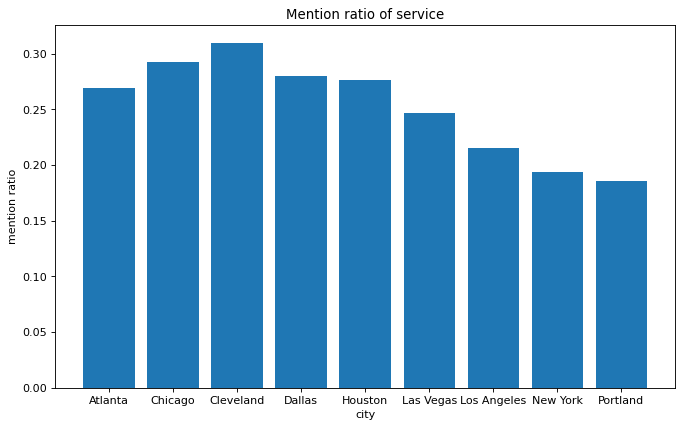

In [14]:
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=80)

plt.bar(service_ratio.index,service_ratio)
plt.xlabel('city')
plt.ylabel('mention ratio')
plt.title('Mention ratio of service')
plt.show()

Cleveland has the highest mention reviews regarding service, and Portland has the lowest mention reviews regarding service. 

### Hamburger review analysis

In [15]:
hamburger = review_finder(text,'cleaned_reviews','hamburger')
no_review_per_city = text.groupby('city').count()['index']
hamburger_reviews = hamburger.groupby('city').count()['index']
hamburger_ratio = hamburger_reviews/no_review_per_city

Finding matching reviews for hamburger in cleaned_reviews of the given dataframe


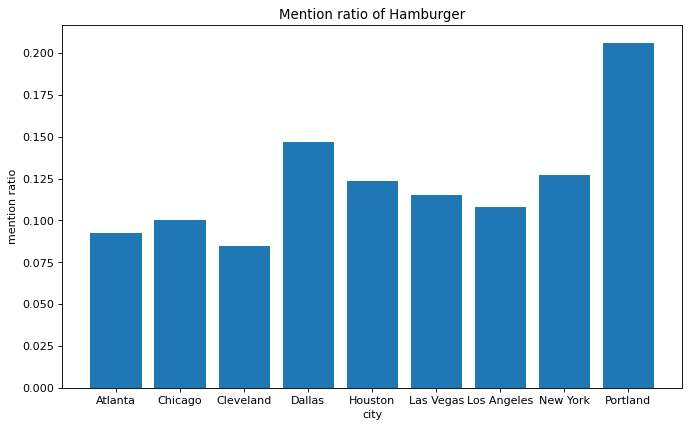

In [16]:
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=80)

plt.bar(hamburger_ratio.index,hamburger_ratio)
plt.xlabel('city')
plt.ylabel('mention ratio')
plt.title('Mention ratio of Hamburger')
plt.show()

Portland has a huge spike of the mentions of hamburgers in their negative reviews

### Facility review analysis

In [17]:
facility = review_finder(text,'cleaned_reviews','facility')

no_review_per_city = text.groupby('city').count()['index']
facility_reviews = facility.groupby('city').count()['index']
facility_ratio = facility_reviews/no_review_per_city

Finding matching reviews for facility in cleaned_reviews of the given dataframe


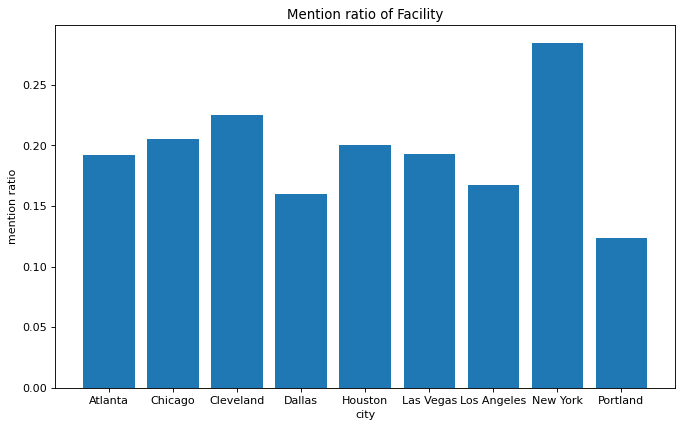

In [18]:
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=80)

plt.bar(facility_ratio.index,facility_ratio)
plt.xlabel('city')
plt.ylabel('mention ratio')
plt.title('Mention ratio of Facility')
plt.show()

While New York was not ranked high in the previous two graphs(service, hamburger), reviews mentioning facility issues spiked high. This could point out that the main issue for McDonalds in New York is the facility.

## McDonalds Summary 

To aid in our analysis of the negative McDonalds reviews, we started by cleaning the reviews by executing the follwing steps:

    1. Removing punctuation
    2. Lemmetizing using part of speech
    3. Remove stopwords based on NLTK and our custom list 
    4. Group common concepts using both regex and results from the McDonalds Menu we webscraped
 
Then we used the word count to find the main concepts we want to analyze. We decided to analyze service, hamburger, and facility, we gleamed the follwing insight from the visualizations above: 


**Key Takeaways**

Cleveland showed high mentions in all three fields, meaning it could do better with some actions to improve. However, New York showed a high increase in mention ratio in facilty. This shows that many  McDonalds customers in New York shows dissatisfaction regarding their facilties. We can also infer that Portland has a problem with burger quality due to its huge spike in proportion of reviews mentioning burgers. 

**Considerations and Next Steps:** 

While this analysis is limited to certain fields of management in McDonalds business, and may not cover all words that could be described as facility, our approach could be used in more various ways and in more depth in the future.





# Tale of Two Cities Practice


B. **Stopwords, Stemming, Lemmatization Practice**

Using the `tale-of-two-cities.txt` file from Week 1:
* Count-vectorize the corpus. Treat each sentence as a document.

How many features (dimensions) do you get when you:
* Perform **stemming** and then count-vectorization
* Perform **lemmatization** and then **count-vectorization**.
* Perform **lemmatization**, remove **stopwords**, and then perform **count-vectorization**?

In [19]:
tale = open("tale-of-two-cities.txt", "r")
tale_lines = tale.readlines()
tale_lines

['  IT WAS the best of times, it was the worst of times, it was the\n',
 'age of wisdom, it was the age of foolishness, it was the epoch of\n',
 'belief, it was the epoch of incredulity, it was the season of Light,\n',
 'it was the season of Darkness, it was the spring of hope, it was the\n',
 'winter of despair, we had everything before us, we had nothing\n',
 'before us, we were all going direct to Heaven, we were all going\n',
 'direct the other way- in short, the period was so far like the present\n',
 'period, that some of its noisiest authorities insisted on its being\n',
 'received, for good or for evil, in the superlative degree of\n',
 'comparison only.\n',
 '  There were a king with a large jaw and a queen with a plain face, on\n',
 'the throne of England; there were a king with a large jaw and a\n',
 'queen with a fair face, on the throne of France. In both countries\n',
 'it was clearer than crystal to the lords of the State preserves of\n',
 'loaves and fishes, that things

## Count-vectorize the corpus. Treat each sentence as a document.


In [20]:
#remove all newlines and punctuation
text_less_newlines = ''
for line in tale_lines:
    clean_tale_lines = re.sub(r"\n",' ',line)
    text_less_newlines += clean_tale_lines

In [21]:
#create sentences which we will treat as documents
sent_text = nltk.sent_tokenize(text_less_newlines)

vectorizer = CountVectorizer(lowercase = True)
word_vectors = vectorizer.fit_transform(sent_text)
vectorizer.get_feature_names()
word_vectors = word_vectors.toarray()
corpus_df = pd.DataFrame(word_vectors, columns=vectorizer.get_feature_names())
print(f"No Treatment we have {len(corpus_df.columns)} features")


No Treatment we have 9705 features


## Perform **stemming** and then count-vectorization


In [22]:
#tokenize into sentences then words, then stem and reconstruct into sentences
stemmer = PorterStemmer()
stemmed_tale= []
for line in sent_text:
    words_clean = []
    for word in nltk.word_tokenize(line): 
        stemmed_word = stemmer.stem(word)
        words_clean.append(stemmed_word)
    stemmed_words = " ".join(words_clean)
    stemmed_tale.append(stemmed_words)

In [23]:
vectorizer = CountVectorizer()
word_vectors = vectorizer.fit_transform(stemmed_tale)
vectorizer.get_feature_names()
word_vectors = word_vectors.toarray()
corpus_df = pd.DataFrame(word_vectors, columns=vectorizer.get_feature_names())
print(f"With Stemming we have {len(corpus_df.columns)} features")

With Stemming we have 6659 features


## Perform **lemmatization** and then **count-vectorization**.

In [24]:
#tokenize into sentences then words, then stem and reconstruct into sentences
Lemmatizer = WordNetLemmatizer()
lemmed_tale= []
for line in sent_text:
    words_clean = []
    for word in nltk.word_tokenize(line): 
        lemmed_word = Lemmatizer.lemmatize(word)
        words_clean.append(lemmed_word)
    lemmed_words = " ".join(words_clean)
    lemmed_tale.append(lemmed_words)

In [25]:
vectorizer = CountVectorizer()
word_vectors = vectorizer.fit_transform(lemmed_tale)
vectorizer.get_feature_names()
word_vectors = word_vectors.toarray()
corpus_df = pd.DataFrame(word_vectors, columns=vectorizer.get_feature_names())
print(f"With Lemmatization we have {len(corpus_df.columns)} features")

With Lemmatization we have 8910 features


## Perform **lemmatization**, remove **stopwords**, and then perform **count-vectorization**?

In [26]:
Lemmatizer = WordNetLemmatizer()
lemm_stopwords = (set(stopwords.words('english')))
lemmed_tale= []

for line in sent_text:
    words_clean = []
    for word in nltk.word_tokenize(line): 
        if word in lemm_stopwords:
            continue
        lemmed_word = Lemmatizer.lemmatize(word)
        words_clean.append(lemmed_word)
    lemmed_words = " ".join(words_clean)
    lemmed_tale.append(lemmed_words)

In [27]:
vectorizer = CountVectorizer()
word_vectors = vectorizer.fit_transform(lemmed_tale)
vectorizer.get_feature_names()
word_vectors = word_vectors.toarray()
corpus_df = pd.DataFrame(word_vectors, columns=vectorizer.get_feature_names())
print(f"With Lemmatization we have {len(corpus_df.columns)} features")

With Lemmatization we have 8897 features


## Tales of two Cities Summary
    - With No Treatment we have 9705 features
    - With Stemming we have 6659 features
    - With Lemmatization 8910 features
    - With Lemmatization and stopwords we have 8897 features